In [27]:
from itertools import cycle
import numpy as np
import pandas as pd
from sklearn.linear_model import lasso_path
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LassoCV
import matplotlib.gridspec as gridspec
from yellowbrick.regressor import ResidualsPlot


In [2]:
seed = 93
random.seed(seed)
np.random.seed(seed)
sqft_train = pd.read_csv("sqft_train.csv")
sqft_test = pd.read_csv("sqft_test.csv")
print(sqft_train.columns)

Index(['air.level', 'base.num', 'baths', 'beds', 'busi.level', 'covered.fee',
       'garage.fee', 'has.covered', 'has.garage', 'has.lot', 'has.street',
       'lot.fee', 'neighborhood', 'pet.allowed', 'pet.deposit', 'pet.fee',
       'pet.rent', 'shopping.num', 'sqft', 'traffic.level', 'zip', 'lat',
       'lng', 'has.parking', 'bed_count', 'bath_count', 'has.pub.elementary',
       'has.priv.elementary', 'has.pub.mid', 'has.cha.high', 'has.priv.high',
       'count.pub.high', 'pub.elt.mid', 'priv.elt.mid', 'has.cha.mid.high',
       'has.priv.mid.high', 'has.pub.mid.high', 'priv.el.hi', 'cha.elt.mid.hi',
       'priv.elt.mid.hi', 'PC1', 'PC2', 'PC3', 'PC4'],
      dtype='object')


In [3]:
sqft_tr_X = sqft_train.loc[:, sqft_train.columns != "sqft"]
sqft_tr_Y = sqft_train.loc[:, "sqft"]
sqft_ts_X = sqft_test.loc[:, sqft_test.columns != "sqft"]
sqft_ts_Y = sqft_test.loc[:, "sqft"]

categories = [
    'air.level', 'base.num', 'busi.level', 'has.covered', 'has.garage',
    'has.lot', 'has.street', 'neighborhood', 'pet.allowed',
    'traffic.level', 'has.parking', 'has.pub.elementary',
    'has.priv.elementary', 'has.pub.mid', 'has.cha.high',
    'has.priv.high', 'count.pub.high', 'pub.elt.mid', "bed_count", "bath_count",
    'priv.elt.mid', 'has.cha.mid.high', 'has.priv.mid.high', 'has.pub.mid.high',
    'priv.el.hi', 'cha.elt.mid.hi', 'priv.elt.mid.hi', "zip"
]

sqft_tr_X = pd.get_dummies(sqft_tr_X, columns=categories)
sqft_ts_X = pd.get_dummies(sqft_ts_X, columns=categories)

In [4]:
lasso_cv = LassoCV(max_iter=50000, cv=10, random_state=seed).fit(sqft_tr_X, sqft_tr_Y)

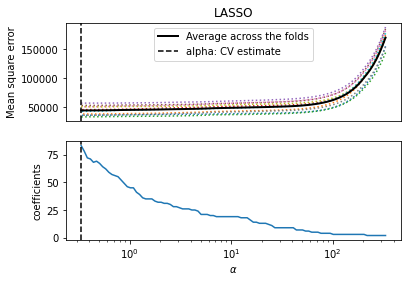

In [5]:
gs = gridspec.GridSpec(2,1)
fig = plt.figure()
ax = fig.add_subplot(gs[0])
ax.semilogx(lasso_cv.alphas_, lasso_cv.mse_path_, linestyle=":")
ax.plot(
    lasso_cv.alphas_,
    lasso_cv.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
ax.axvline(lasso_cv.alpha_, linestyle="--", color="black", label="alpha: CV estimate")
ax.set_ylabel("Mean square error")
ax.legend()
ax.set_title(
    "LASSO"
)
ax.axes.get_xaxis().set_visible(False)

ax = fig.add_subplot(gs[1], sharex=ax)
alphas_lasso, coefs_lasso, _ = lasso_path(sqft_tr_X, sqft_tr_Y,
                                          alphas=lasso_cv.alphas_,
                                          max_iter=50000)
colors = cycle(["b", "r", "g", "c", "k"])
coef_count = []
for i, _ in enumerate(alphas_lasso):
    count = 0
    for coefs in coefs_lasso:
        if coefs[i] != 0:
            count += 1
    coef_count.append(count)

ax.semilogx(alphas_lasso, coef_count)
ax.axvline(lasso_cv.alpha_, linestyle="--", color="black", label="alpha: CV estimate")
ax.set_ylabel("coefficients")
ax.set_xlabel(r"$\alpha$")
plt.show()


In [6]:
coef_idx = lasso_cv.coef_ != 0
coefficients = lasso_cv.coef_[coef_idx]
coefficients = pd.Series(coefficients, sqft_tr_X.columns[coef_idx])
coefficients.abs().sort_values(ascending=False)
selected_tr_X = sqft_tr_X[coefficients.index]

In [7]:
random_forest = RandomForestRegressor(random_state=seed)
params = {
    "n_estimators": range(1, 1001, 50)
}
random_tree_cv = GridSearchCV(estimator=random_forest, param_grid=params, n_jobs=-1,
                              cv=10, scoring="neg_mean_squared_error")
random_tree_cv.fit(selected_tr_X, sqft_tr_Y)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=93), n_jobs=-1,
             param_grid={'n_estimators': range(1, 1001, 50)},
             scoring='neg_mean_squared_error')

In [8]:
cv_rf_result = pd.DataFrame(random_tree_cv.cv_results_)
cv_rf_result.loc[cv_rf_result.rank_test_score == 1,
                 ["params", "mean_test_score", "std_test_score"]]

,params,mean_test_score,std_test_score
19,{'n_estimators': 951},-36230.838109,5385.750579


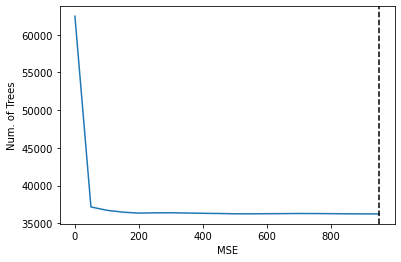

In [9]:
plt.plot(range(1, 1001, 50), -cv_rf_result["mean_test_score"])
plt.xlabel("MSE")
plt.ylabel("Num. of Trees")
plt.axvline(random_tree_cv.best_params_["n_estimators"],
            linestyle="--", color="black", label="number of trees: CV")
plt.show()

In [10]:
best_rf = random_tree_cv.best_estimator_
rf_perm_imp = permutation_importance(best_rf, selected_tr_X, sqft_tr_Y,
                                     n_repeats=10, n_jobs=-1, random_state=seed)

Text(0.5, 1.0, 'Perm. Feature Importance')

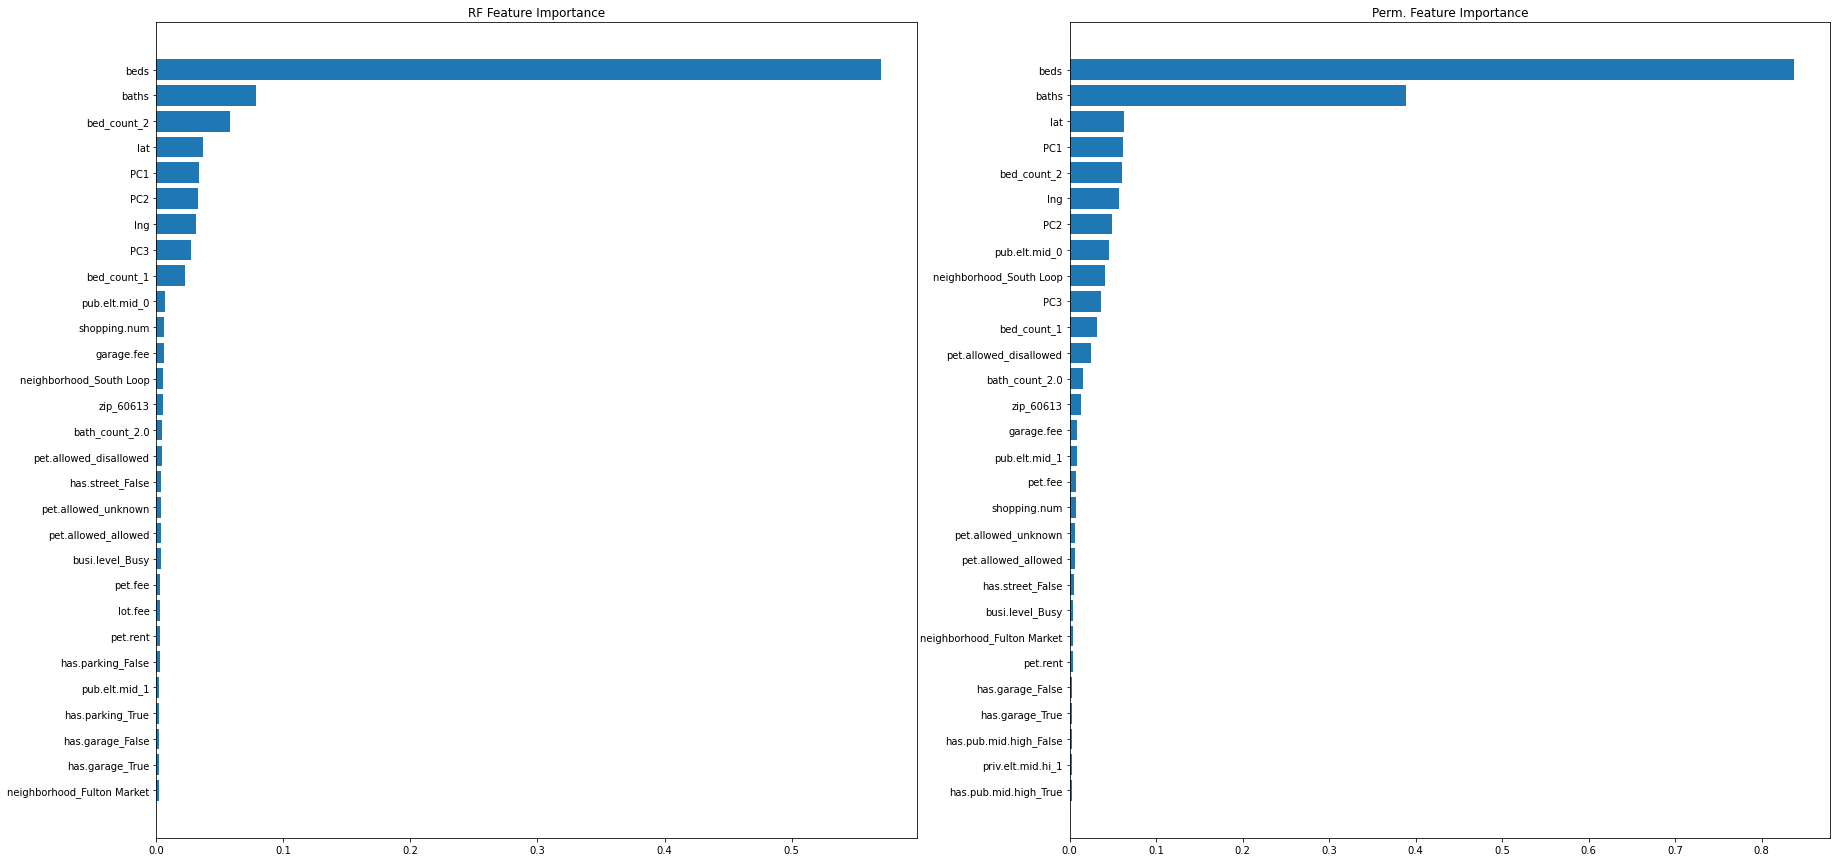

In [11]:
gs = gridspec.GridSpec(1,2)
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(30)
ax = fig.add_subplot(gs[0])
rf_features = pd.Series(best_rf.feature_importances_,
                        selected_tr_X.columns).sort_values(ascending=True)[50:]
feature_pos = np.arange(len(rf_features))
ax.barh(feature_pos, rf_features)
plt.sca(ax)
plt.yticks(feature_pos, rf_features.index)
plt.title("RF Feature Importance")

ax = fig.add_subplot(gs[1])
rf_perm_imp_s = pd.Series(rf_perm_imp.importances_mean,
                        selected_tr_X.columns).sort_values(ascending=True)[50:]
ax.barh(feature_pos, rf_perm_imp_s)
plt.sca(ax)
plt.yticks(feature_pos, rf_perm_imp_s.index)
plt.title("Perm. Feature Importance")

In [12]:
rf_tr = best_rf.predict(sqft_tr_X[coefficients.index])
rf_ts = best_rf.predict(sqft_ts_X[coefficients.index])

rf_tr_mse = mean_squared_error(sqft_tr_Y, rf_tr)
rf_ts_mse = mean_squared_error(sqft_ts_Y, rf_ts)
rf_tr_mae = mean_absolute_error(sqft_tr_Y, rf_tr)
rf_ts_mae = mean_absolute_error(sqft_ts_Y, rf_ts)

rf_perf = pd.DataFrame({
    "train.mse": [rf_tr_mse],
    "test.mse": [rf_ts_mse],
    "train.mae": [rf_tr_mae],
    "test.mae": [rf_ts_mae]
})
rf_perf = pd.Series([rf_tr_mse, rf_ts_mse, rf_tr_mae, rf_ts_mae],
                    index=["train.mse", "test.mse", "train.mae", "test.mae"])
rf_perf

train.mse     7981.037667
test.mse     30385.424969
train.mae       54.122640
test.mae       104.683902
dtype: float64

In [13]:
relevant_features = set(rf_features.index[-9:])
relevant_features = relevant_features.union(set(rf_perm_imp_s.index[-12: ]))
selected_tr_X = selected_tr_X.loc[:, relevant_features]
selected_ts_X = sqft_ts_X.loc[:, relevant_features]

In [14]:
random_tree_cv = GridSearchCV(estimator=random_forest, param_grid=params, n_jobs=-1,
                              cv=10, scoring="neg_mean_squared_error")
random_tree_cv.fit(selected_tr_X, sqft_tr_Y)


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=93), n_jobs=-1,
             param_grid={'n_estimators': range(1, 1001, 50)},
             scoring='neg_mean_squared_error')

In [15]:
cv_rf_result = pd.DataFrame(random_tree_cv.cv_results_)
cv_rf_result.loc[cv_rf_result.rank_test_score == 1,
                 ["params", "mean_test_score", "std_test_score"]]

,params,mean_test_score,std_test_score
10,{'n_estimators': 501},-35856.391159,5229.91933


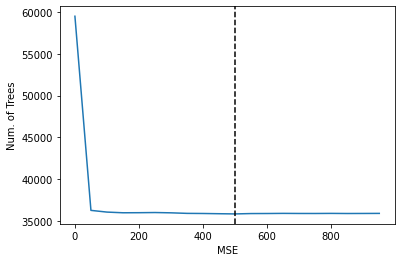

In [26]:
plt.plot(range(1, 1001, 50), -cv_rf_result["mean_test_score"])
plt.xlabel("MSE")
plt.ylabel("Num. of Trees")
plt.axvline(random_tree_cv.best_params_["n_estimators"],
            linestyle="--", color="black", label="number of trees: CV")
plt.show()

In [16]:
best_rf = random_tree_cv.best_estimator_
rf_tr = best_rf.predict(selected_tr_X)
rf_ts = best_rf.predict(selected_ts_X)

rf_tr_mse = mean_squared_error(sqft_tr_Y, rf_tr)
rf_ts_mse = mean_squared_error(sqft_ts_Y, rf_ts)
rf_tr_mae = mean_absolute_error(sqft_tr_Y, rf_tr)
rf_ts_mae = mean_absolute_error(sqft_ts_Y, rf_ts)

rf_perf = pd.Series([rf_tr_mse, rf_ts_mse, rf_tr_mae, rf_ts_mae],
                    index=["train.mse", "test.mse", "train.mae", "test.mae"])
rf_perf

train.mse     9684.448675
test.mse     30144.155085
train.mae       59.047821
test.mae       104.749086
dtype: float64

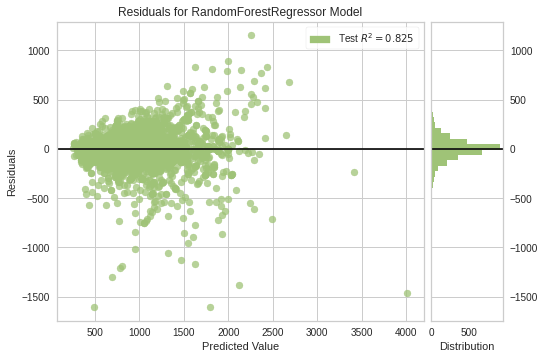

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [28]:
rs_plot = ResidualsPlot(best_rf)
rs_plot.score(selected_ts_X, sqft_ts_Y)
rs_plot.show()

In [22]:
svr = SVR()
svr_param = {
    "gamma": ["scale"] + list(np.arange(0.0001, 0.6, 0.05)),
    "C": np.arange(950, 1050, 10),
    "epsilon": range(75, 125, 5)
}
svr_cv = GridSearchCV(estimator=svr, param_grid=svr_param, n_jobs=-1,
                              cv=10, scoring="neg_mean_squared_error")
svr_cv.fit(selected_tr_X, sqft_tr_Y)

GridSearchCV(cv=10, estimator=SVR(), n_jobs=-1,
             param_grid={'C': array([ 950,  960,  970,  980,  990, 1000, 1010, 1020, 1030, 1040]),
                         'epsilon': range(75, 125, 5),
                         'gamma': ['scale', 0.0001, 0.050100000000000006,
                                   0.10010000000000001, 0.1501, 0.2001, 0.2501,
                                   0.30010000000000003, 0.3501, 0.4001, 0.4501,
                                   0.5001, 0.5501]},
             scoring='neg_mean_squared_error')

In [23]:
cv_svr_result = pd.DataFrame(svr_cv.cv_results_)
cv_svr_result.loc[cv_svr_result.rank_test_score == 1,
                 ["params", "mean_test_score", "std_test_score"]]


,params,mean_test_score,std_test_score
699,"{'C': 1000, 'epsilon': 90, 'gamma': 0.4501}",-43184.246233,7803.839871


In [25]:
best_svr = svr_cv.best_estimator_
svr_tr = best_svr.predict(selected_tr_X)
svr_ts = best_svr.predict(selected_ts_X)

svr_tr_mse = mean_squared_error(sqft_tr_Y, svr_tr)
svr_ts_mse = mean_squared_error(sqft_ts_Y, svr_ts)
svr_tr_mae = mean_absolute_error(sqft_tr_Y, svr_tr)
svr_ts_mae = mean_absolute_error(sqft_ts_Y, svr_ts)

svr_perf = pd.Series([svr_tr_mse, svr_ts_mse, svr_tr_mae, svr_ts_mae],
                    index=["train.mse", "test.mse", "train.mae", "test.mae"])
svr_perf



train.mse    27806.681374
test.mse     40313.753861
train.mae      103.852427
test.mae       125.375988
dtype: float64

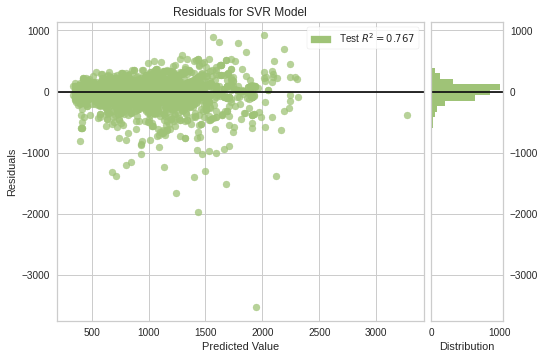

<AxesSubplot:title={'center':'Residuals for SVR Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [29]:
rs_plot = ResidualsPlot(best_svr)
rs_plot.score(selected_ts_X, sqft_ts_Y)
rs_plot.show()